In [11]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.set_printoptions(precision=1,suppress=True)

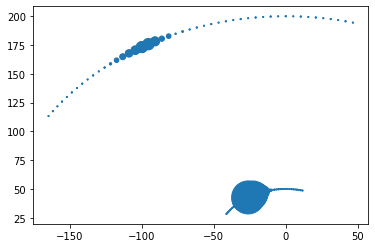

In [12]:
rh = RoundHill()
X = rh.experiments[0].X
Y = rh.experiments[0].Y #scaling
boundary = proposeboundary(X)
boundary[0][2]=-30 #puts the source on the grid!
boundary[0][0]=-120 #add two minutes to start

dist = np.round(X[:,2]**2+X[:,3]**2).astype(int)
keep = dist==10000 #2500, 10000, 40000
Xtest = X[keep,:]
Ytest = Y[keep]
X = X[~keep,:]
Y = Y[~keep]
plt.scatter(X[:,2],X[:,3],Y+1)

In [101]:
#set up our model...
N_feat = 10000 #Number of features used to infer the source
Nparticles = 20
#k = EQ(np.array([50,12,12]), 1000)
k = EQ(np.array([50,10,10]), 1000)
res = [100,100,100]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
print("Memory usage in grid model: %0.2f Gb" % gbs)
#assert gbs<6, "TOO BIG :("
noiseSD = 0.1
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(rh.experiments[0].windX,rh.experiments[0].windY)
k_0 = 1
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
mInfer.computeModelRegressors(Nparticles=Nparticles) # Compute regressor matrix
print("Computed Regressors")
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix

Nsamps = 1
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)

#concmean,concvar = mInfer.computeConcentration(meanZ,covZ,Nsamps=5,Nparticles=25,interpolateSource=True)
scaleby = [8,1,1]
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]]
concmean,concvar,concentrations = mInfer.computeConcentration(Nparticles=Nparticles,Zs=Zs,interpolateSource=True,coords=coords)

gridsource = mInfer.getGridCoord(np.array([0,0,0])) #location of ground truth source
gridX = mInfer.getGridCoord(X[:,1:])/np.array(scaleby) #grid-coords of X (inputs)
mInferCoords = mInfer.coords

testsensors = FixedSensorModel(Xtest,3)
particles = mInfer.genParticlesFromObservations(100,testsensors)[None,None,:,:,:].transpose([3,0,1,2,4])
meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=Zs,interpolateSource=True)

Memory usage in grid model: 1.79 Gb
Initialising particles...
Diffusing particles...
Computed Regressors
Computing SS...
Inverting SS...
Computing meanZ
Done
cache miss, computing source from phi...
Computing Source from Phi...
Initialising particles...
Particle shape:
(20, 13, 100, 100, 3)
Diffusing particles...
Initialising particles...
Particle shape:
(100, 1, 1, 117, 3)
Diffusing particles...


Text(0, 0.5, 'Pred')

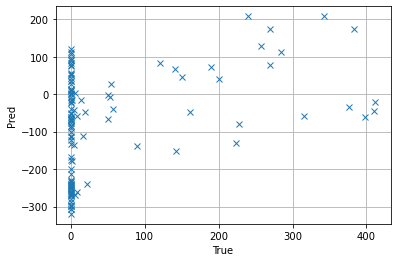

In [154]:
keep = Xtest[:,1]>=0
preds = meanobs[0,0,:].copy()
#preds[preds<0]=0
plt.plot(Ytest[keep],preds[keep],'x')
plt.grid()
plt.xlabel('True')
plt.ylabel('Pred')

23


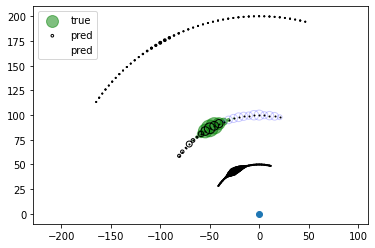

In [183]:
keep = Xtest[:,1]==600
print(sum(keep))
plt.scatter(Xtest[keep,2],Xtest[keep,3],Ytest[keep],c='green',alpha=0.5,label='true')
plt.scatter(Xtest[keep,2],Xtest[keep,3],meanobs[0,0,keep],alpha=1,c='none',edgecolors='k',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],-meanobs[0,0,keep],alpha=0.2,c='none',edgecolors='b',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],1,c='k')
plt.scatter(X[:,2],X[:,3],1+Y/20,c='k')
plt.plot([0],[0],'o')
plt.axis('equal')
plt.legend()

In [184]:
import GPy
k = GPy.kern.RBF(3,ARD=True,lengthscale=30)
m = GPy.models.GPRegression(X,Y[:,None],k)
m.Gaussian_noise = 2
#m.optimize()
m.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],30.0,+ve,
[1],30.0,+ve,
[2],30.0,+ve,


23


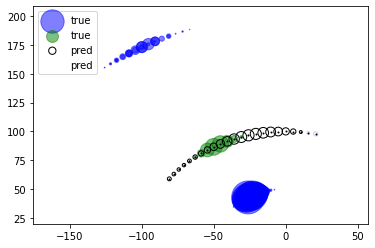

In [185]:
GPpreds, _ = m.predict(Xtest)
#keep = Xtest[:,1]==600
#GPpreds[GPpreds<0]=0
print(sum(keep))
plt.scatter(X[:,2],X[:,3],Y,c='blue',alpha=0.5,label='true')
plt.scatter(Xtest[keep,2],Xtest[keep,3],Ytest[keep],c='green',alpha=0.5,label='true')
plt.scatter(Xtest[keep,2],Xtest[keep,3],GPpreds[keep],alpha=1,c='none',edgecolors='k',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],-GPpreds[keep],alpha=0.2,c='none',edgecolors='b',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],1,c='k')
plt.legend()

In [194]:
def MAE(a):
    return np.mean(np.abs(a))
def RMSE(a):
    return np.sqrt(np.mean(a**2))
def MSE(a):
    return np.mean(a**2)

print(" Time     GP   Adjoint")
for t in [30,180,600]:
    keep = Xtest[:,1]==t
    thresholdGPpreds = GPpreds.copy()
    #thresholdGPpreds[thresholdGPpreds<0]=0
    thresholdpreds = preds.copy()
    #thresholdpreds[thresholdpreds<0]=0
    #MAE(Ytest[keep]-GPpreds[keep,0]),MAE(Ytest[keep]-preds[keep])
    #RMSE(Ytest[keep]-GPpreds[keep,0]),RMSE(Ytest[keep]-preds[keep])
    print("%5d: %6.0f %6.0f" % (t,MSE(Ytest[keep]-thresholdGPpreds[keep,0]),MSE(Ytest[keep]-thresholdpreds[keep])))

 Time     GP   Adjoint
   30:  21749  60957
  180:  13086  25944
  600:   8506   6218


In [ ]:
(21748.70210856546, 20179.661009869782)
(13086.187603829614, 3766.36976)
(8506.370135801708, 3946.)